In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [210]:
global_temp_byCountry = pd.read_csv("GlobalLandTemperaturesByCountry.csv")

In [122]:
global_temp_byCountry['dt'] = pd.to_datetime(global_temp_byCountry['dt'])
global_temp_byCountry['Year'] = global_temp_byCountry['dt'].dt.year
global_temp_byCountry=global_temp_byCountry.dropna()

avg_temp = np.array([])
year = np.array([],dtype=int)

for index,row in global_temp_byCountry.iterrows():
    if row['Country']=='United States':
        avg_temp = np.append(avg_temp,row['AverageTemperature'])
        year = np.append(year,row['Year'])
        

In [123]:
master_array = zip(avg_temp,year)
data = pd.DataFrame(master_array,columns=['AverageTemperature','Year'])    

In [124]:
maxTemps = data.groupby((data['Year']//10)*10)['AverageTemperature'].max().reset_index()
maxTemps= maxTemps.rename(columns={"AverageTemperature": "MaxTemperature"})

minTemps = data.groupby((data['Year']//10)*10)['AverageTemperature'].min().reset_index()
minTemps= minTemps.rename(columns={"AverageTemperature": "MinTemperature"})


In [125]:
MaxMinTemp = maxTemps.merge(minTemps,how='right',left_on='Year',right_on='Year')
MaxMinTemp = MaxMinTemp[MaxMinTemp['Year']>1900]

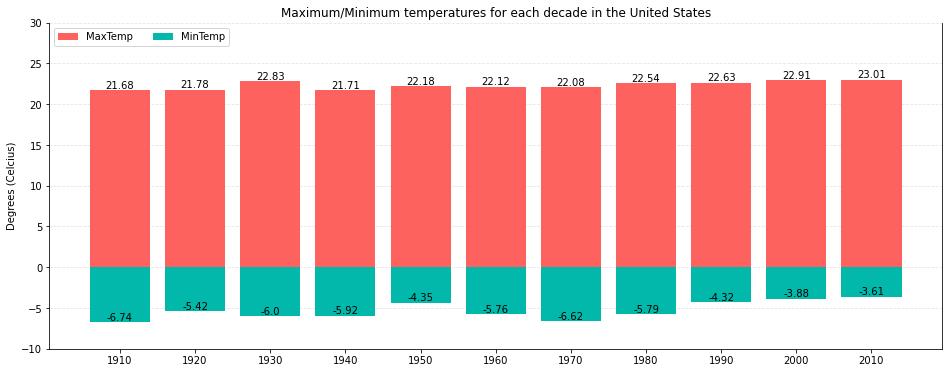

In [126]:
fig, ax = plt.subplots(1, figsize=(16, 6))
plt.bar(MaxMinTemp['Year'], MaxMinTemp['MaxTemperature'], width = 8, color = '#fd625e')
plt.bar(MaxMinTemp['Year'], MaxMinTemp['MinTemperature'], width = 8, color = '#01b8aa')

# remove spines
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(False)


plt.ylabel('Degrees (Celcius)')
plt.xticks(MaxMinTemp['Year'])

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.2)

labels = round(pd.concat([MaxMinTemp['MaxTemperature'],MaxMinTemp['MinTemperature']]),2)

for r, label in zip(ax.patches, labels):
    height = r.get_height()
    ax.text(r.get_x() + r.get_width() / 2, height, label, ha="center", va="bottom")

plt.ylim(-10, 30)
plt.title('Maximum/Minimum temperatures for each decade in the United States')
plt.legend(['MaxTemp', 'MinTemp'], loc='upper left', ncol = 2)
plt.show()

In [79]:
#plotting temperature anomalies

In [384]:
global_temp_byCountry['dt'] = pd.to_datetime(global_temp_byCountry['dt'])
global_temp_byCountry['Year'] = global_temp_byCountry['dt'].dt.year
global_temp_byCountry=global_temp_byCountry.dropna()

anom_data= global_temp_byCountry[global_temp_byCountry['Country']=='Russia']
anom_data= anom_data[anom_data['dt']>'1900-01-01']

In [385]:
anom_data= anom_data[(anom_data['Year']>=1950) & (anom_data['Year']<2010)]
monthly_mean = anom_data.groupby((anom_data['dt'].dt.month))['AverageTemperature'].mean().reset_index()
monthly_mean= monthly_mean.rename(columns={'dt':'month','AverageTemperature':'monthly_mean'})
anom_data = anom_data.merge(monthly_mean,how='right',left_on=anom_data['dt'].dt.month,right_on='month')
anom_data['Anomaly'] = 0

In [386]:
for index,rows in anom_data.iterrows():
    diff = rows['AverageTemperature'] - (rows['monthly_mean'])
    if diff >= 2:
        anom_data.iloc[index,7] = 1
        #US_data['Anomaly'][index] = 1 
    elif diff <=-2:
        anom_data.iloc[index,7] = 2
        #US_data['Anomaly'][index] = 2

In [387]:
max_anom = anom_data[anom_data['Anomaly']==1]
min_anom = anom_data[anom_data['Anomaly']==2]

In [388]:
max_count = max_anom.groupby((max_anom['Year']//10)*10)['Anomaly'].count().reset_index()
min_count = min_anom.groupby((min_anom['Year']//10)*10)['Anomaly'].count().reset_index()
max_count= max_count.rename(columns={'Anomaly':'max_anom_count'})
min_count= min_count.rename(columns={'Anomaly':'min_anom_count'})

maxmin_anom = max_count.merge(min_count,how='right',left_on='Year',right_on='Year')
maxmin_anom

,Year,max_anom_count,min_anom_count
0,1950,4,17
1,1960,6,17
2,1970,4,14
3,1980,12,11
4,1990,19,5
5,2000,22,5


<ipython-input-389-f8ada2d98348>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(abs(tick)) for tick in ticks])


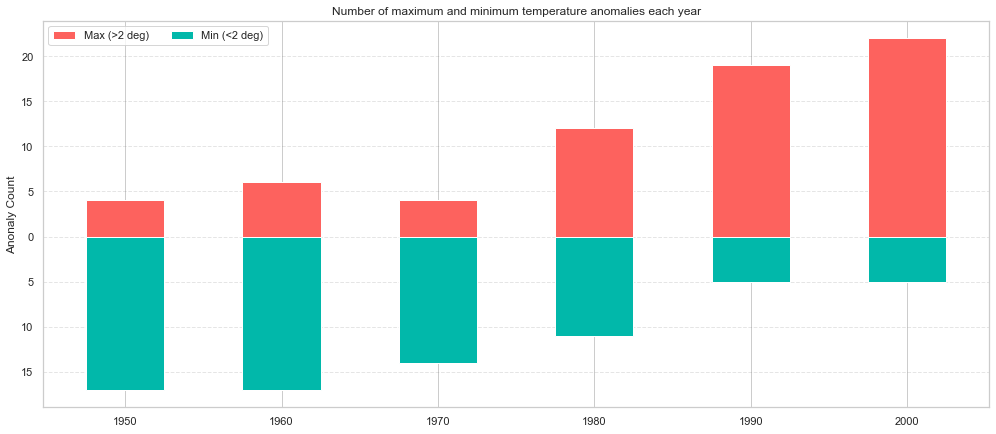

In [389]:
fig, ax = plt.subplots(1, figsize=(14, 6))
plt.bar(maxmin_anom['Year'], maxmin_anom['max_anom_count'], width = 5, color = '#fd625e')
plt.bar(maxmin_anom['Year'], -1*maxmin_anom['min_anom_count'], width = 5, color = '#01b8aa')

plt.ylabel('Anonaly Count')
plt.xticks(maxmin_anom['Year'])

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.2)
#ax.set_xticks(ax.get_xticks()[::2]) 
ticks =  ax.get_yticks()
ax.set_yticklabels([int(abs(tick)) for tick in ticks])


plt.tight_layout()
plt.title('Number of maximum and minimum temperature anomalies each year')
plt.legend(['Max (>2 deg)', 'Min (<2 deg)'], loc='upper left', ncol = 2)
plt.show()